# Clasificación de dígitos con redes de convolución

## Introduction

In this notebook, we are going to create a classifier for the mnist problem using a Convolutional Neural Network (CNN) model.

A CNN is a somewhat different architecture of a neural network that, while maintaining its feed-forward behavior, leverages the structure of the input data (usually images, but generalizing to any dataset where related values tend to be close) to reduce the model's size and, at the same time, provide better performance.

## Libraries and Configuration
Next, we will import the libraries that will be used throughout the notebook.

In [13]:
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras.utils import to_categorical

We will also configure some parameters to adjust the graphical presentation.

In [14]:
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams.update({'figure.figsize': (20, 6),'figure.dpi': 64})

***

## Data Pre-process

Let's take a closer look at the data we'll be working with. The mnist dataset consists of small images (28x28 pixels) containing handwritten digits from 0 to 9.

![](https://upload.wikimedia.org/wikipedia/commons/2/27/MnistExamples.png)


Indeed, keras provides a module to work with this dataset directly without any hassle. Let's load it and take a closer look.

In [15]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

print(f'Training shape: {x_train.shape} input, {y_train.shape} output')
print(f'Test shape:     {x_test.shape} input, {y_test.shape} output')

Training shape: (60000, 28, 28) input, (60000,) output
Test shape:     (10000, 28, 28) input, (10000,) output


We can see that the dataset is divided into a training set with 60,000 examples and a test set with 10,000 examples. We will use the training set to train our model, while the test set will be used to evaluate the model's performance on data it has never seen before.

lets see the shape of a particular example

In [16]:
INDEX = 42

print(x_train[INDEX])

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   1  26 111 195 230
   30   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0  28 107 195 254 25

Each example is a matrix of 28x28 numerical values ranging from 0 to 255. This is because the values are bytes representing the intensity of white, where 0 stands for totally black and 255 for totally white.

Let's visualize one of these numbers using the matplotlib library as a heatmap:

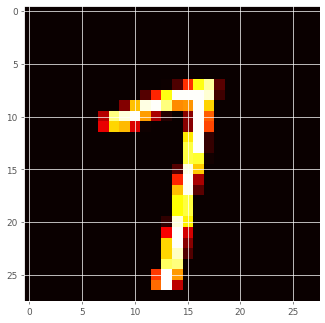

In [17]:
plt.imshow(x_train[INDEX], cmap='hot');

When working with neural networks, it is common to normalize inputs to the range [0, 1]. We can take advantage of the power of numpy and broadcasting (applying a function to all elements of a vector or matrix) to normalize the values. If the maximum value is 255, the process is as simple as follows:

In [18]:
x_train = x_train / 255
x_test = x_test / 255

We have just performed a division on both input datasets. Now, if we display the content of our number (well, a portion of it), we will see that it is normalized:

In [19]:
print(x_train[INDEX][5:10])

[[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.00392157 0.10196078 0.43529412 0.76470588 0.90196078
  0.11764706 0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.10980392
  0

The relative relationships between the values have not changed, so if we display the heatmap, we will see that the relative differences between values have been preserved:

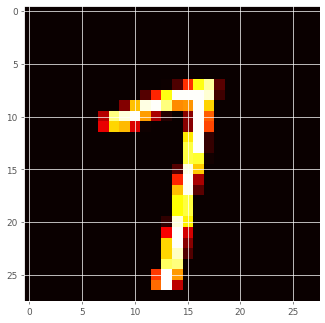

In [20]:
plt.imshow(x_train[INDEX], cmap='hot');

By the way, we have chosen a quite intriguing number since it is difficult to decide whether it's a 1 or a 7 (at least to me). Let's see its output value and continue from there.

In [21]:
print(y_train[INDEX])

7


Now, what we are going to deal with is a problem related to **multiclass classification**. When we work with two classes, having one output neuron that discriminates between the two makes sense. Let's suppose we have a problem to identify whether a photo corresponds to a cat or not. If we use an output neuron with sigmoid activation, the closer it gets to 0 or 1, the further it moves away from 1 or 0. In other words, the more certain we are that it's a cat, the more certain we are that it's not a non-cat.

Now, let's consider a scenario where we want to indicate if a photo contains a cat, a dog, or a bear. What do we do with just one neuron? Do we assign intervals? Remember, neural networks work with a process called gradient descent that operates with small error increments. Having a range of real values from 0 to 1, there's an ordering among these values. So, how do we set the intervals? Is the bear in between? Is the bear a mixture of dog and cat? How do we go from dog to cat if gradient descent will lead us away from the bear because the error will be very high?

Well, the solution is to use as many neurons as classes we want to classify. Each neuron will correspond to a 'is/not is' something, and in the end, we choose the neuron with the highest activation. To achieve this, Keras provides a tool among its utilities that converts numerical values into categories, performing a one-hot encoding. It works by sorting the values and converting each of the different values into a position in the output vector.

In [22]:
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

print(y_train[INDEX])

[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


This encoding transforms the numerical value into an ordered array where the neuron corresponding to the answer is activated. In this way, we now have an output value that we can compare with the output of our network, which will have 10 neurons (corresponding to the 10 numbers to be classified). And now, yes, we have our data prepared.

## The model

Let's create a simple CNN without multiple independent branches or complex elements, so we can use the Sequential API smoothly. If we recall, the Sequential model is created as a list of layers that are connected one after the other. However, there is another way to build it by using the add method of the Sequential class objects.

Let's start by creating the Sequential model:

In [23]:
model_cnn = tf.keras.Sequential()

Now, let's add a hidden layer. As we recall from the theory, CNNs consist of two parts: the feature extraction part, composed of convolutional layers, and the inference part, composed of dense layers. We'll start with a convolutional layer:

In [24]:
model_cnn.add(tf.keras.layers.Conv2D(
    input_shape=(28, 28, 1),
    kernel_size=(3, 3),
    filters=8,
    activation='relu',
))

We have just created a layer composed of 8 convolutions of size $3 \times 3 \times 1$ that will navigate through the entire image, extracting features.

Another layer that is often combined with convolutional layers is the partial subsampling or pooling layer. If we remember, it used filters to reduce the image by taking the most prominent values from each area covered by the filter. In this case, we will use a `MaxPooling2D` layer that will select the highest value within the area it covers, with a stride equal to the filter size to avoid overlapping. This will significantly reduce the output size of the previous layer:

In [25]:
model_cnn.add(tf.keras.layers.MaxPooling2D(
    pool_size=(2, 2),
    strides=(2, 2)
))


For now, let's keep a single convolutional layer and a pooling layer and move on to the inference part.

However, to proceed to the inference part (which is essentially a multilayer perceptron), we need all the input data to be in one dimension. Therefore, before entering the inference layer, we will "flatten" the output of the convolution:

In [26]:
model_cnn.add(tf.keras.layers.Flatten())

You are right; we don't need any parameters for flattening. It simply reshapes the multidimensional matrix into two dimensions, combining the number of examples with all the extracted features for each example.

Now, let's add the dense layers as needed. Let's start by adding a hidden dense layer:

In [27]:
model_cnn.add(tf.keras.layers.Dense(4, activation='relu'))

And the output layer. Remember, the output will have **10 neurons**, one for each possible class.

In [28]:
model_cnn.add(tf.keras.layers.Dense(10, activation='softmax'))

Correct, the reason we add a softmax activation function is that:

1. The class to be selected is exclusive, meaning an example cannot belong to multiple classes at the same time.
2. Softmax is differentiable (in fact, it is the differentiable version of the argmax function), making it possible to apply the gradient descent algorithm to train the network.

With this, we have defined our model. Let's see its structure:

In [29]:
model_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 26, 26, 8)         80        
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 8)         0         
 D)                                                              
                                                                 
 flatten_1 (Flatten)         (None, 1352)              0         
                                                                 
 dense_3 (Dense)             (None, 4)                 5412      
                                                                 
 dense_4 (Dense)             (None, 10)                50        
                                                                 
Total params: 5542 (21.65 KB)
Trainable params: 5542 (21.65 KB)
Non-trainable params: 0 (0.00 Byte)
____________________

Let's compare it to a multilayer perceptron with a couple of hidden layers and approximately the same number of parameters:

In [30]:
model_mlp = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(7, activation='relu'),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax'),
])
model_mlp.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 784)               0         
                                                                 
 dense_5 (Dense)             (None, 7)                 5495      
                                                                 
 dense_6 (Dense)             (None, 8)                 64        
                                                                 
 dense_7 (Dense)             (None, 10)                90        
                                                                 
Total params: 5649 (22.07 KB)
Trainable params: 5649 (22.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


let's see how they perform in a couple of training sessions. To do this, we will train them with the same algorithms and the same number of epochs. Let's start with the CNN.

In [31]:
model_cnn.compile(
    loss = tf.keras.losses.CategoricalCrossentropy(),
    optimizer = tf.keras.optimizers.SGD(),
    metrics = [tf.keras.metrics.CategoricalAccuracy()]
)
history_cnn = model_cnn.fit(x_train, y_train, epochs=50, validation_split=0.1)

Epoch 1/50
1688/1688 [==============================] - 4s 2ms/step - loss: 1.4362 - categorical_accuracy: 0.4813 - val_loss: 0.8466 - val_categorical_accuracy: 0.7093
Epoch 2/50
1688/1688 [==============================] - 3s 2ms/step - loss: 0.8021 - categorical_accuracy: 0.7346 - val_loss: 0.6873 - val_categorical_accuracy: 0.7695
Epoch 3/50
1688/1688 [==============================] - 3s 2ms/step - loss: 0.6245 - categorical_accuracy: 0.8056 - val_loss: 0.5046 - val_categorical_accuracy: 0.8520
Epoch 4/50
1688/1688 [==============================] - 3s 2ms/step - loss: 0.5039 - categorical_accuracy: 0.8502 - val_loss: 0.4003 - val_categorical_accuracy: 0.8830
Epoch 5/50
1688/1688 [==============================] - 3s 2ms/step - loss: 0.4356 - categorical_accuracy: 0.8734 - val_loss: 0.3458 - val_categorical_accuracy: 0.9045
Epoch 6/50
1688/1688 [==============================] - 3s 2ms/step - loss: 0.3911 - categorical_accuracy: 0.8875 - val_loss: 0.3311 - val_categorical_accuracy:

lets see the error and accuracy history for the training and validation sets:

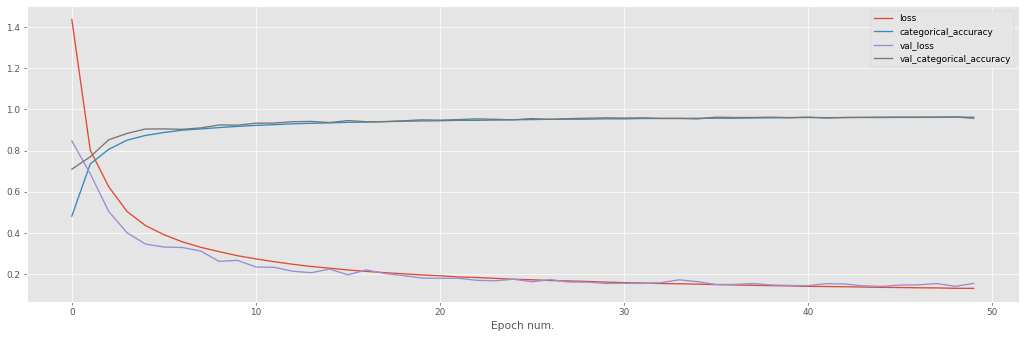

In [32]:
pd.DataFrame(history_cnn.history).plot()
plt.xlabel('Epoch num.')
plt.show()

Now its MLP's turn:

In [33]:
model_mlp.compile(
    loss = tf.keras.losses.CategoricalCrossentropy(),
    optimizer = tf.keras.optimizers.SGD(),
    metrics = [tf.keras.metrics.CategoricalAccuracy()]
)
history_mlp = model_mlp.fit(x_train, y_train, epochs=50, validation_split=0.1)

Epoch 1/50
1688/1688 [==============================] - 1s 353us/step - loss: 1.2229 - categorical_accuracy: 0.5839 - val_loss: 0.6106 - val_categorical_accuracy: 0.8148
Epoch 2/50
1688/1688 [==============================] - 1s 326us/step - loss: 0.5793 - categorical_accuracy: 0.8243 - val_loss: 0.4391 - val_categorical_accuracy: 0.8728
Epoch 3/50
1688/1688 [==============================] - 1s 315us/step - loss: 0.4758 - categorical_accuracy: 0.8604 - val_loss: 0.3911 - val_categorical_accuracy: 0.8818
Epoch 4/50
1688/1688 [==============================] - 1s 314us/step - loss: 0.4261 - categorical_accuracy: 0.8770 - val_loss: 0.3417 - val_categorical_accuracy: 0.8998
Epoch 5/50
1688/1688 [==============================] - 1s 315us/step - loss: 0.3952 - categorical_accuracy: 0.8869 - val_loss: 0.3205 - val_categorical_accuracy: 0.9042
Epoch 6/50
1688/1688 [==============================] - 1s 316us/step - loss: 0.3759 - categorical_accuracy: 0.8915 - val_loss: 0.3022 - val_categoric

lets see the error and accuracy history for the training and validation sets:

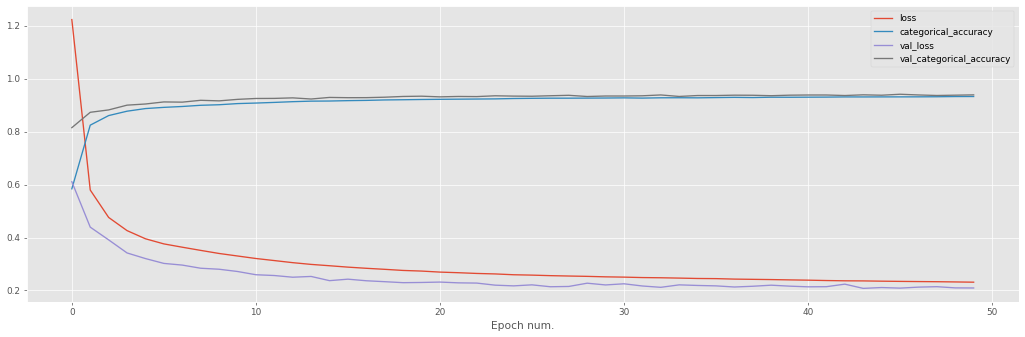

In [34]:
pd.DataFrame(history_mlp.history).plot()
plt.xlabel('Epoch num.')
plt.show()

It appears that, although the MLP performs quite well, the network cannot achieve as much accuracy as the CNN. This makes sense since many of the parameters in the CNN are used to relate pixels that are likely to have very little to do with each other. Let's see how they perform with the test set:

In [35]:
loss_cnn, acc_cnn = model_cnn.evaluate(x_test, y_test)
loss_mlp, acc_mlp = model_mlp.evaluate(x_test, y_test)

print(f'Results for CNN: Loss={loss_cnn}, acc={acc_cnn}')
print(f'Results for MLP: Loss={loss_mlp}, acc={acc_mlp}')

313/313 [==============================] - 0s 340us/step - loss: 0.2564 - categorical_accuracy: 0.9250
Results for CNN: Loss=0.1709715873003006, acc=0.9516000151634216
Results for MLP: Loss=0.2563748061656952, acc=0.925000011920929


we've made a slight oversight. Our convolutional network only has one layer, and this causes the output to be quite large. When connecting it to the dense layer, it dramatically increases the number of parameters.

Let's try to fix this and compare it with a new multilayer perceptron.

In [36]:
model = tf.keras.models.Sequential([
    # Capa convolucional
    tf.keras.layers.Conv2D(kernel_size=(3,3), filters=8, activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2, 2)),
    # Capa convolucional
    tf.keras.layers.Conv2D(kernel_size=(3,3), filters=8, activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2, 2)),
    # Aplanamos características
    tf.keras.layers.Flatten(),
    # Inferencia
    tf.keras.layers.Dense(8, activation='sigmoid'),
    tf.keras.layers.Dense(10, activation='softmax'),
])
model.compile(
    loss = tf.keras.losses.CategoricalCrossentropy(),
    optimizer = tf.keras.optimizers.SGD(),
    metrics = [tf.keras.metrics.CategoricalAccuracy()]
)
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 26, 26, 8)         80        
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 13, 13, 8)         0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 11, 11, 8)         584       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 5, 5, 8)           0         
 g2D)                                                            
                                                                 
 flatten_3 (Flatten)         (None, 200)               0         
                                                                 
 dense_8 (Dense)             (None, 8)                

Almost half the trainable parameters, lets see how it performs:

In [37]:
history = model.fit(x_train, y_train, epochs=50, validation_split=0.1)

Epoch 1/50
1688/1688 [==============================] - 4s 3ms/step - loss: 2.0164 - categorical_accuracy: 0.3900 - val_loss: 1.5054 - val_categorical_accuracy: 0.6567
Epoch 2/50
1688/1688 [==============================] - 4s 3ms/step - loss: 1.2519 - categorical_accuracy: 0.7269 - val_loss: 0.9928 - val_categorical_accuracy: 0.8175
Epoch 3/50
1688/1688 [==============================] - 4s 3ms/step - loss: 0.8991 - categorical_accuracy: 0.8214 - val_loss: 0.7310 - val_categorical_accuracy: 0.8737
Epoch 4/50
1688/1688 [==============================] - 4s 2ms/step - loss: 0.6820 - categorical_accuracy: 0.8715 - val_loss: 0.5691 - val_categorical_accuracy: 0.9000
Epoch 5/50
1688/1688 [==============================] - 4s 2ms/step - loss: 0.5369 - categorical_accuracy: 0.8985 - val_loss: 0.4354 - val_categorical_accuracy: 0.9272
Epoch 6/50
1688/1688 [==============================] - 4s 2ms/step - loss: 0.4374 - categorical_accuracy: 0.9162 - val_loss: 0.3518 - val_categorical_accuracy:

the metric history:

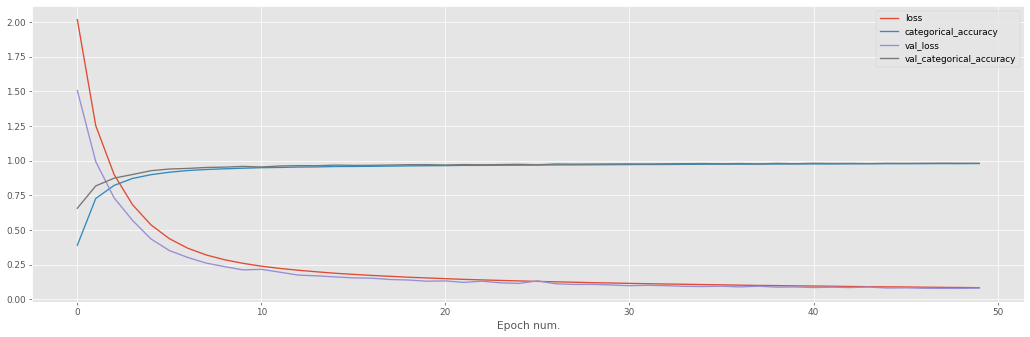

In [38]:
pd.DataFrame(history.history).plot()
plt.xlabel('Epoch num.')
plt.show()

Parece un entrenamiento más estable y con mejores valores. Comparemos ahora los resultados de los tres modelos con el conjunto de test.

In [39]:
loss, acc = model.evaluate(x_test, y_test)

print(f'Results for CNN 2.0: Loss={loss}, acc={acc}')
print(f'Results for CNN:     Loss={loss_cnn}, acc={acc_mlp}')
print(f'Results for MLP:     Loss={loss_mlp}, acc={acc_cnn}')

313/313 [==============================] - 0s 875us/step - loss: 0.0943 - categorical_accuracy: 0.9755
Results for CNN 2.0: Loss=0.09427637606859207, acc=0.9754999876022339
Results for CNN:     Loss=0.1709715873003006, acc=0.925000011920929
Results for MLP:     Loss=0.2563748061656952, acc=0.9516000151634216


The CNN model generalizes better than the rest, and it also occupies almost half the parameters. It seems that the CNN architecture performs significantly better for this type of problem.

However, it does have a drawback, which we might have identified: the training speed. After all, convolution operations are slower than simple matrix products.

If you require faster training, you may consider using hardware accelerators like GPUs or TPUs. They are well-suited for parallelizing these computationally intensive operations and can significantly speed up the training process.

In summary, for image-related tasks, especially with limited data, CNNs are generally a powerful and effective choice. They excel at feature extraction and are capable of learning hierarchical representations from raw data, making them ideal for tasks like image recognition and classification.

## LeNet & AlexNet Models

The LeNet convolutional neural network model is one of the first neural networks that utilized convolution operations. It was proposed by Yann LeCun in 1989 for the handwritten digit recognition (i.e., classification) problem.

LeNet is the model that inspired AlexNet, the model that won the ImageNet competition in 2012 and is considered the origin of the deep learning frenzy that has brought us to the current state.


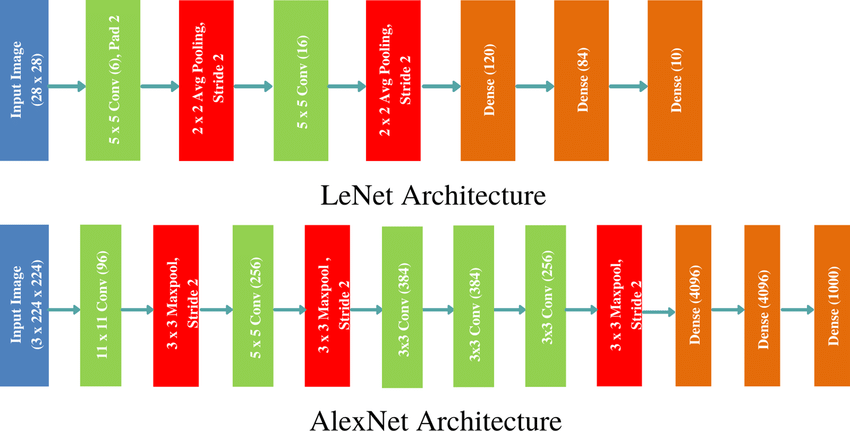

We will now create these architectures to see how they perform with this dataset.

### Arquitectura LeNet

there are many different variants and adaptations of the LeNet architecture. The one we implemented earlier is based on the structure shown in Figure 1, but it is not the original version, as the original LeNet architecture takes input images of size $32 \times 32$.

In [40]:
lenet = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(6, 5, padding='same', activation='sigmoid', input_shape=(28, 28, 1)),
    tf.keras.layers.AveragePooling2D(2),
    tf.keras.layers.Conv2D(16, 5, activation='sigmoid'),
    tf.keras.layers.AveragePooling2D(2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(120, activation='sigmoid'),
    tf.keras.layers.Dense(84, activation='sigmoid'),
    tf.keras.layers.Dense(10, activation='softmax'),
])
lenet.compile(
    loss = tf.keras.losses.CategoricalCrossentropy(),
    optimizer = tf.keras.optimizers.SGD(),
    metrics = [tf.keras.metrics.CategoricalAccuracy()]
)
lenet.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 28, 28, 6)         156       
                                                                 
 average_pooling2d_2 (Avera  (None, 14, 14, 6)         0         
 gePooling2D)                                                    
                                                                 
 conv2d_6 (Conv2D)           (None, 10, 10, 16)        2416      
                                                                 
 average_pooling2d_3 (Avera  (None, 5, 5, 16)          0         
 gePooling2D)                                                    
                                                                 
 flatten_4 (Flatten)         (None, 400)               0         
                                                                 
 dense_10 (Dense)            (None, 120)              

This architecture has significantly more parameters than the ones we have been dealing with so far. Let's see how the training progresses over 50 epochs, just like in the previous examples.

In [41]:
lenet_history = lenet.fit(x_train, y_train, epochs=50, validation_split=0.1)

Epoch 1/50
1688/1688 [==============================] - 5s 3ms/step - loss: 2.3044 - categorical_accuracy: 0.1094 - val_loss: 2.3041 - val_categorical_accuracy: 0.1050
Epoch 2/50
1688/1688 [==============================] - 5s 3ms/step - loss: 2.3032 - categorical_accuracy: 0.1079 - val_loss: 2.3057 - val_categorical_accuracy: 0.1050
Epoch 3/50
1688/1688 [==============================] - 5s 3ms/step - loss: 2.3031 - categorical_accuracy: 0.1083 - val_loss: 2.3051 - val_categorical_accuracy: 0.1050
Epoch 4/50
1688/1688 [==============================] - 5s 3ms/step - loss: 2.3028 - categorical_accuracy: 0.1090 - val_loss: 2.3042 - val_categorical_accuracy: 0.0992
Epoch 5/50
1688/1688 [==============================] - 5s 3ms/step - loss: 2.3028 - categorical_accuracy: 0.1085 - val_loss: 2.3033 - val_categorical_accuracy: 0.0952
Epoch 6/50
1688/1688 [==============================] - 5s 3ms/step - loss: 2.3027 - categorical_accuracy: 0.1107 - val_loss: 2.3042 - val_categorical_accuracy:

metrics history:

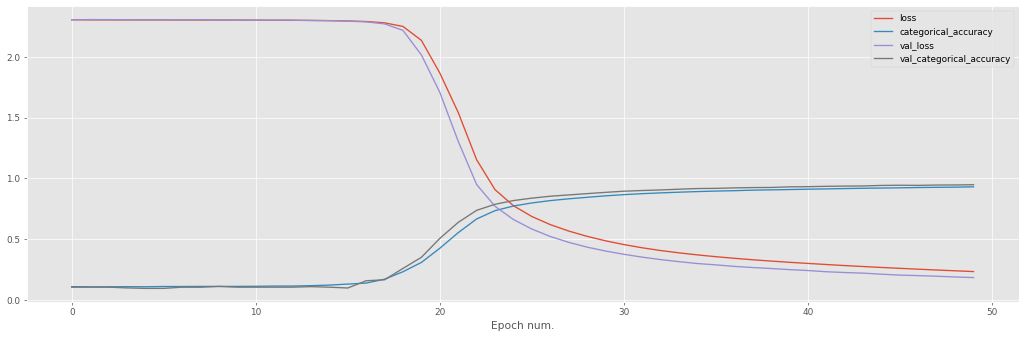

In [42]:
pd.DataFrame(lenet_history.history).plot()
plt.xlabel('Epoch num.')
plt.show()

### Arquitectura AlexNet

As we have seen, the AlexNet architecture is an extension of the LeNet architecture designed for the ImageNet competition, which involved classifying images of size $224 \times 224 \times 3$ into one of a thousand classes.

Unlike with LeNet, here we will implement a slightly different version than the one shown in Figure 2:

1. The last layer will have 10 neurons instead of 1000, as we need to classify 10 digits.
2. We will reduce the dimensions of the convolution and pooling filters because the input image is not large enough to support them (they would shrink below zero pixels).
3. We will also remove the strides for the same reason.

In [43]:
alexnet = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(96, 3, activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D(2),
    tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(2),
    tf.keras.layers.Conv2D(384, 3, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(384, 3, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(3),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10, activation='softmax'),
])
alexnet.compile(
    loss = tf.keras.losses.CategoricalCrossentropy(),
    optimizer = tf.keras.optimizers.SGD(),
    metrics = [tf.keras.metrics.CategoricalAccuracy()]
)
alexnet.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 26, 26, 96)        960       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 13, 13, 96)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 13, 13, 256)       221440    
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 6, 6, 256)         0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 6, 6, 384)         885120    
                                                                 
 conv2d_10 (Conv2D)          (None, 6, 6, 384)        

This architecture has significantly more parameters than the ones we have been dealing with so far. Additionally, it includes two dropout layers, which we will explain in more detail later. For now, they are there to reduce overfitting during training.

Let's see how the training progresses over 50 epochs, just like in the previous examples.

In [44]:
alexnet_history = lenet.fit(x_train, y_train, epochs=50, validation_split=0.1)

Epoch 1/50
1688/1688 [==============================] - 5s 3ms/step - loss: 0.2274 - categorical_accuracy: 0.9320 - val_loss: 0.1781 - val_categorical_accuracy: 0.9483
Epoch 2/50
1688/1688 [==============================] - 6s 3ms/step - loss: 0.2216 - categorical_accuracy: 0.9334 - val_loss: 0.1752 - val_categorical_accuracy: 0.9493
Epoch 3/50
1688/1688 [==============================] - 6s 3ms/step - loss: 0.2161 - categorical_accuracy: 0.9354 - val_loss: 0.1688 - val_categorical_accuracy: 0.9520
Epoch 4/50
1688/1688 [==============================] - 5s 3ms/step - loss: 0.2108 - categorical_accuracy: 0.9371 - val_loss: 0.1673 - val_categorical_accuracy: 0.9520
Epoch 5/50
1688/1688 [==============================] - 5s 3ms/step - loss: 0.2057 - categorical_accuracy: 0.9385 - val_loss: 0.1615 - val_categorical_accuracy: 0.9545
Epoch 6/50
1688/1688 [==============================] - 5s 3ms/step - loss: 0.2005 - categorical_accuracy: 0.9397 - val_loss: 0.1563 - val_categorical_accuracy:

metrics history:

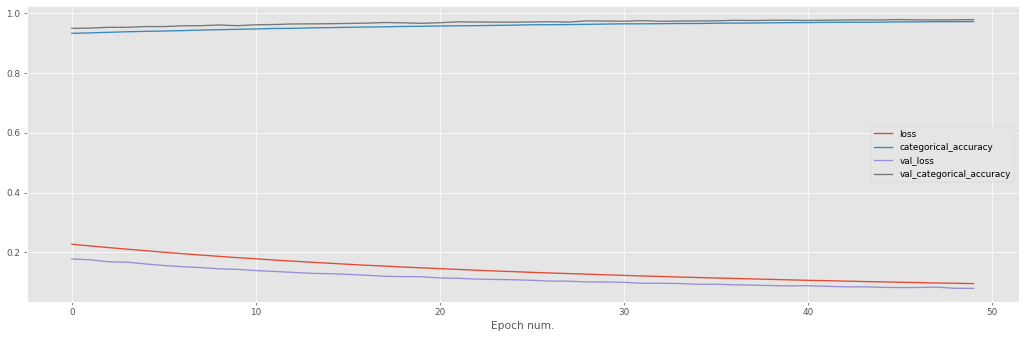

In [45]:
pd.DataFrame(alexnet_history.history).plot()
plt.xlabel('Epoch num.')
plt.show()

lets compare both models:

In [46]:
lenet_loss, lenet_acc = lenet.evaluate(x_test, y_test)
alexnet_loss, alexnet_acc = alexnet.evaluate(x_test, y_test)

print(f'Results for AlexNet: Loss={alexnet_loss}, acc={alexnet_acc}')
print(f'Results for LeNet:   Loss={lenet_loss}, acc={lenet_acc}')
print(f'Results for CNN 2.0: Loss={loss}, acc={acc}')
print(f'Results for CNN:     Loss={loss_cnn}, acc={acc_mlp}')
print(f'Results for MLP:     Loss={loss_mlp}, acc={acc_cnn}')

313/313 [==============================] - 11s 35ms/step - loss: 2.3027 - categorical_accuracy: 0.1147
Results for AlexNet: Loss=2.302675485610962, acc=0.11469999700784683
Results for LeNet:   Loss=0.08488190919160843, acc=0.9729999899864197
Results for CNN 2.0: Loss=0.09427637606859207, acc=0.9754999876022339
Results for CNN:     Loss=0.1709715873003006, acc=0.925000011920929
Results for MLP:     Loss=0.2563748061656952, acc=0.9516000151634216


Perhaps in this example, the power of these models compared to the previous ones is not evident, but the truth is that they outperform them by several orders of magnitude in more complex problems... and also in training time.

## Conclusions

Convolutional neural networks are a neural network architecture that leverages the input's inherent features to learn existing relationships. It is akin to approaching a problem in a more intelligent way than brute force.

Their main drawback is the training speed, but they far surpass problem-solving capabilities when dealing with elements like images.